Error: Image at TEST_METRICS/infected/.ipynb_checkpoints could not be loaded.


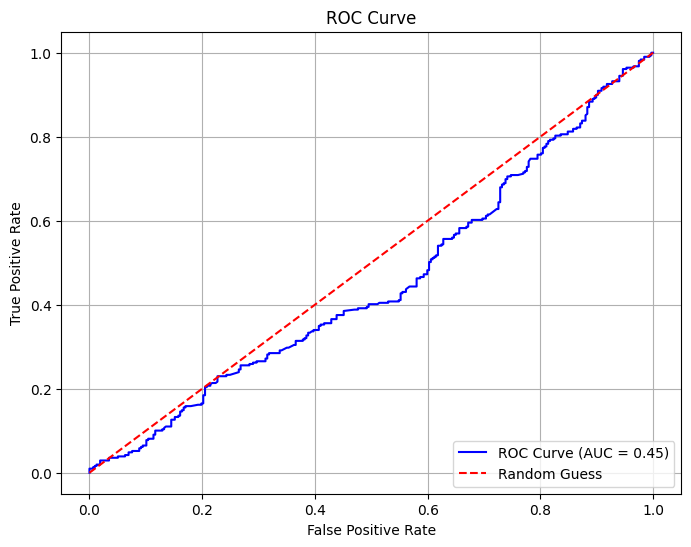


Classification Report:
Accuracy: 0.51
Precision (Uninfected): 0.51
Recall (Uninfected): 1.00
F1-Score (Uninfected): 0.67
Precision (Infected): 1.00
Recall (Infected): 0.01
F1-Score (Infected): 0.01


In [2]:
import cv2
import numpy as np
import xgboost as xgb
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report

# Grad-CAM class
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        def forward_hook(module, input, output):
            self.activations = output

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_tensor, target_class=None):
        self.model.eval()
        output = self.model(input_tensor)
        if target_class is None:
            target_class = torch.argmax(output)
        self.model.zero_grad()
        output[:, target_class].backward()

        gradients = self.gradients.detach().cpu().numpy()
        activations = self.activations.detach().cpu().numpy()
        weights = np.mean(gradients, axis=(2, 3))
        cam = np.zeros(activations.shape[2:], dtype=np.float32)
        for i, w in enumerate(weights[0]):
            cam += w * activations[0, i]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (224, 224))
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        return cam

# Preprocessing function
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Error: Image at {image_path} could not be loaded.")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    return image_tensor

# Load the CNN model for feature extraction
def load_cnn_model():
    model = torchvision.models.vgg16(pretrained=True)
    model.classifier[6] = nn.Linear(in_features=4096, out_features=2)  # Binary classification
    model.eval()
    return model

# Extract features and reshape to match XGBoost input size
def extract_features(image_path, cnn_model, device):
    image_tensor = preprocess_image(image_path).to(device)
    with torch.no_grad():
        features = cnn_model.features(image_tensor)  # Extract convolutional features
        features = features.view(features.size(0), -1)  # Flatten features

        # Ensure the feature vector matches the expected size for XGBoost
        expected_feature_size = 2048  # XGBoost expects this number of features (check during training)
        if features.size(1) > expected_feature_size:
            features = features[:, :expected_feature_size]  # Truncate to match size
        elif features.size(1) < expected_feature_size:
            padding = expected_feature_size - features.size(1)
            features = torch.cat([features, torch.zeros(features.size(0), padding).to(device)], dim=1)  # Pad if smaller

    return features.cpu().numpy()

# Load the XGBoost model
def load_xgboost_model(model_path):
    model = xgb.Booster()  # Initialize the XGBoost Booster
    model.load_model(model_path)  # Load the model from file
    return model

# Predict with XGBoost using CNN features
def predict_with_xgboost(xgb_model, cnn_model, image_path, gradcam=None, device=None, visualize_gradcam=False):
    try:
        features = extract_features(image_path, cnn_model, device)  # Extract features from CNN
    except ValueError as e:
        print(str(e))
        return None

    dmatrix = xgb.DMatrix(features)  # Convert features to DMatrix for XGBoost prediction
    prediction = xgb_model.predict(dmatrix)  # Make prediction using XGBoost

    if gradcam and visualize_gradcam:
        image_tensor = preprocess_image(image_path).to(device)
        cam = gradcam.generate_cam(image_tensor)  # Generate Grad-CAM for visualization
        visualize_gradcam(image_path, cam, prediction)

    return prediction

# Visualize Grad-CAM results
def visualize_gradcam(image_path, cam, prediction):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Image at {image_path} could not be loaded.")
        return
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.imshow(cam, cmap='jet', alpha=0.5)  # Heatmap overlay
    plt.title(f"Prediction: {'Infected' if prediction > 0.5 else 'Uninfected'}")
    plt.axis('off')
    plt.show()

# Evaluate images in a folder
def evaluate_images_in_folder(xgb_model, cnn_model, folder_path, gradcam=None, device=None, visualize_gradcam=False):
    all_labels = []
    all_probs = []

    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)
        if os.path.isdir(subfolder_path):
            ground_truth_label = 1 if subfolder == "infected" else 0  # Folder names as labels
            for filename in os.listdir(subfolder_path):
                image_path = os.path.join(subfolder_path, filename)

                prediction = predict_with_xgboost(xgb_model, cnn_model, image_path, gradcam, device, visualize_gradcam)
                if prediction is not None:
                    all_labels.append(ground_truth_label)
                    all_probs.append(prediction[0])  # Probability of 'Infected'

    return all_labels, all_probs

# Plot ROC Curve
def plot_roc_curve(labels, probabilities):
    fpr, tpr, thresholds = roc_curve(labels, probabilities)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

# Main execution
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load models
    xgb_model_path = "xgboost_cancer_model.json"  # Path to your XGBoost model
    xgb_model = load_xgboost_model(xgb_model_path)
    
    cnn_model = load_cnn_model()  # Load CNN for feature extraction
    gradcam = GradCAM(cnn_model, cnn_model.features[28])  # Grad-CAM target layer

    # Folder path containing images (e.g., "test_eval/infected/" and "test_eval/uninfected/")
    folder_path = "TEST_METRICS"  # Folder containing "infected" and "uninfected"

    # Set this flag to True if you want to visualize Grad-CAM for certain predictions
    visualize_gradcam = False  # Set to True if you want Grad-CAM for every image

    # Evaluate images and plot results
    all_labels, all_probs = evaluate_images_in_folder(xgb_model, cnn_model, folder_path, gradcam, device, visualize_gradcam)
    plot_roc_curve(all_labels, all_probs)

    # Classification report
    report = classification_report(all_labels, np.array(all_probs) > 0.5, target_names=["Uninfected", "Infected"], output_dict=True)
    print("\nClassification Report:")
    print(f"Accuracy: {report['accuracy']:.2f}")
    print(f"Precision (Uninfected): {report['Uninfected']['precision']:.2f}")
    print(f"Recall (Uninfected): {report['Uninfected']['recall']:.2f}")
    print(f"F1-Score (Uninfected): {report['Uninfected']['f1-score']:.2f}")
    print(f"Precision (Infected): {report['Infected']['precision']:.2f}")
    print(f"Recall (Infected): {report['Infected']['recall']:.2f}")
    print(f"F1-Score (Infected): {report['Infected']['f1-score']:.2f}")
